In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import log
from sklearn import linear_model

#comment below if not using ipython notebook
%matplotlib inline

### let's load the data into a dataframe


In [2]:
data  = pd.read_csv('Assignment2.data', sep='\t')
data.head()

,SpringPos,StockPrice
0,2.27,3.48
1,6.38,2.99
2,8.61,5.86
3,8.65,1.79
4,13.17,3.47


In [3]:
data.describe()

,SpringPos,StockPrice
count,226.000000,226.000000
mean,3.785221,14.187743
std,10.704778,7.447450
min,-19.910000,0.670000
25%,-3.960000,8.355000
50%,4.195000,13.970000
75%,11.295000,19.632500
max,26.100000,30.050000


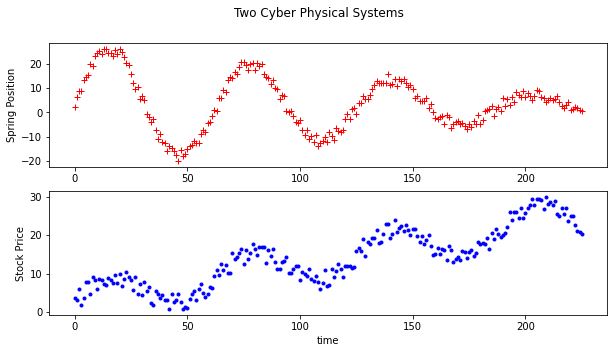

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Two Cyber Physical Systems')
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.plot(data.SpringPos, 'r+')
ax1.set_ylabel('Spring Position')
ax2.plot(data.StockPrice, 'b.')
ax2.set_ylabel('Stock Price')
ax2.set_xlabel('time')

plt.show()

## Fit a linear model on the dataset

In [5]:
y2 = pd.DataFrame({"x":range(226), "y":data.StockPrice})
y2.head()

,x,y
0,0,3.48
1,1,2.99
2,2,5.86
3,3,1.79
4,4,3.47


### transform the data into matrices

In [6]:
yy = np.array(y2.y) 
xx = np.expand_dims(y2.x, 1)

### run the closed form solution to estimate the beta parameter.

In [7]:
numerator = np.matmul(np.transpose(xx), yy)
denom = np.matmul(np.transpose(xx), xx)
denom_inv = np.linalg.inv(denom)
beta = np.matmul(denom_inv, numerator)
print("Beta = ", beta[0])
sse = np.sum((xx*beta[0] - np.expand_dims(yy,1))**2)
print("SSE = ", sse)

Beta =  0.11899412514961837
SSE =  3850.335433080234


### as we will be reusing the above procedure often, let's make it a function

In [8]:
# estimate the value of the beta vector assuming that X is made of independent features.
def estimateBeta(X, y):
    numerator = np.matmul(np.transpose(X), y)
    denom = np.matmul(np.transpose(X), X)
    denom_inv = np.linalg.inv(denom)
    beta = np.matmul(denom_inv, numerator)
    return beta

# create a helper that would estimate yhat from X and beta.
def predict(beta, X):
    # reshape the input to a matrix, if it is appearing like an 1d array.
    if len(X.shape) != 2:
        X = np.expand_dims(X,1)
    # convert the beta list in to an array.
    beta = np.array(beta)
    # perform estimation of yhat.
    return np.matmul(X, beta)

# compute the sum of squared error between y and yhat.
def SSE(y, yhat):
    return np.sum((y-yhat)**2)

### Let's plot the raw data and the regression line on the same plot

Text(0.5, 0, 'Time')

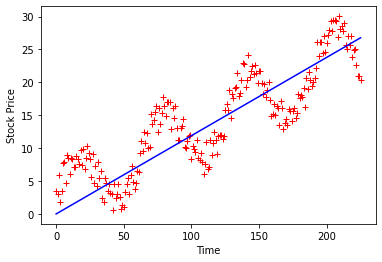

In [9]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat1, 'b-')  # yhat = y2.x*beta[0]
plt.ylabel('Stock Price')
plt.xlabel('Time')

### let's add an intercept (bias) to the data and check if the SSE drops further.

In [10]:
y2df = pd.DataFrame({"bias":np.ones(226), "x":range(226), "y":data.StockPrice})
yy = np.array(y2df.y) 
xx = np.array(y2df[["bias","x"]])
y2df.head()

,bias,x,y
0,1.0,0,3.48
1,1.0,1,2.99
2,1.0,2,5.86
3,1.0,3,1.79
4,1.0,4,3.47


### estimate the beta params and compute the loss again

In [11]:
beta2 = estimateBeta(xx, yy)
print("beta =", beta2)
yhat2 = predict(beta2, xx)
loss = SSE(yy, yhat2)
print("SSE =", loss)

beta = [3.18244786 0.09782485]
SSE = 3274.298469663405


### interesting! the loss has dropped with a little bit on intercept.  Let's plot it side by side.

Text(0.5, 0, 'Time')

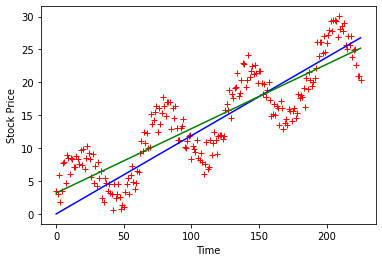

In [12]:
plt.plot(y2df.x, y2df.y, 'r+')
plt.plot(y2df.x, yhat1, 'b-')
plt.plot(y2df.x, yhat2, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')

### Let's model the periodicity

Let's borrow the slope information from the fit to set up the scale of the time axis.

Instead of using $x$ in integer scale, we shall use the floating point scale as $x_1 \leftarrow \beta_0 * x$

Likewise, let's create a new data dimension to capture the periodicity as $x_2 \leftarrow sin(x_1)$

Based on the expanded feature space, now let's try to model $\hat{y} = m_1 x_1 + m_2 x_2$, note that we don't have to use the intercept $c$ as our previous linear model passed through the origin.


### create a feature space appropriately

In [13]:
x1 = round(y2.x*beta2[1],2)
x2 = np.sin(x1)

y21 = pd.DataFrame({"bias":np.ones(226),"x":range(226), "x1":x1, "x2":x2, "y":data.StockPrice})
y21.head(10)

,bias,x,x1,x2,y
0,1.0,0,0.00,0.000000,3.48
1,1.0,1,0.10,0.099833,2.99
2,1.0,2,0.20,0.198669,5.86
3,1.0,3,0.29,0.285952,1.79
4,1.0,4,0.39,0.380188,3.47
5,1.0,5,0.49,0.470626,7.73
6,1.0,6,0.59,0.556361,7.83
7,1.0,7,0.68,0.628793,4.70
8,1.0,8,0.78,0.703279,8.97
9,1.0,9,0.88,0.770739,8.43


### create the data matrices from the data frame

In [14]:
xx = np.array(y21[['bias', 'x1', 'x2']])
yy = np.array(y2.y) 

In [15]:
beta3 = estimateBeta(xx, yy)
print("Beta = ", beta3)
yhat3 = predict(beta3, xx)
loss = SSE(yy, yhat3) #np.sum((np.matmul(xx,beta) - yy)**2)
print("SSE = ", loss)

Beta =  [2.74436632 1.00020159 4.82388129]
SSE =  701.3625743495965


### Let's plot the raw data and the regression line on the same plot

Text(0.5, 0, 'Time')

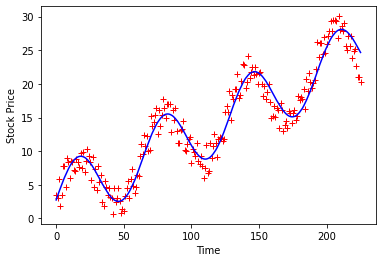

In [16]:
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat3, 'b-')
plt.ylabel('Stock Price')
plt.xlabel('Time')

### we were able to see the sin(x) from the visual.  what if we can't visualize? let's try the polynomial fit.

In [17]:
x1 = round(y2.x*beta2[1],2)

y21 = pd.DataFrame({"bias":np.ones(226),"x":range(226), "x1":x1, "y":data.StockPrice})
y21.head(10)

,bias,x,x1,y
0,1.0,0,0.00,3.48
1,1.0,1,0.10,2.99
2,1.0,2,0.20,5.86
3,1.0,3,0.29,1.79
4,1.0,4,0.39,3.47
5,1.0,5,0.49,7.73
6,1.0,6,0.59,7.83
7,1.0,7,0.68,4.70
8,1.0,8,0.78,8.97
9,1.0,9,0.88,8.43


### create the data matrices from the data frame

In [18]:
# here we don't need the explicit bias feature column, as polynomial features would include it already (x^0 = 1)
xx = np.array(y21[['x1']])
yy = np.array(y2.y) 

### let's use the polynomial features generator instead of manually doing it.

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 50)   # 10, 11
X_poly = poly_transformer.fit_transform(xx)

### fit the model and estimate the loss

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_poly, yy)
print("Intercept=", model.intercept_, "Beta = ", model.coef_)
yhat4 = model.predict(X_poly)

#beta4 = estimateBeta(X_poly, yy)
#print("Beta = ", beta4)
#yhat4 = predict(beta4, X_poly)

loss = SSE(yy, yhat4)
print("SSE = ", loss)

Intercept= 11.474642529013542 Beta =  [-1.06171580e-055  2.25050010e-054  3.34040933e-057  5.75402230e-061
  5.59427495e-063  1.10232970e-065  2.15637650e-101  1.29766935e-095
  2.05624764e-094  3.29371967e-093  5.31953270e-092  8.64523316e-091
  1.41161019e-089  2.31275017e-088  3.79791848e-087  6.24530511e-086
  1.02750517e-084  1.69004297e-083  2.77699720e-082  4.55521601e-081
  7.45408777e-080  1.21597940e-078  1.97601623e-077  3.19639258e-076
  5.14266303e-075  8.22244660e-074  1.30524466e-072  2.05499525e-071
  3.20519668e-070  4.94600052e-069  7.53975538e-068  1.13346574e-066
  1.67695361e-065  2.43579832e-064  3.46336716e-063  4.80326321e-062
  6.46866806e-061  8.41135406e-060  1.04827084e-058  1.23972055e-057
  1.37220165e-056  1.39320913e-055  1.25764030e-054  9.57116965e-054
  5.52885602e-053  1.82828800e-052 -4.46830729e-053  4.24589337e-054
 -2.00348872e-055  4.71424990e-057 -4.43130470e-059]
SSE =  5859.376404290878


### Let's plot the raw data and the regression line on the same plot

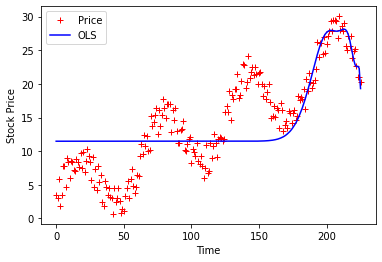

In [21]:
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat4, 'b-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Price', 'OLS'], loc='upper left')
plt.show()

### Brilliant, how to I find the best degree automatically without performing a linear search!

In [22]:
from sklearn.linear_model import Lasso, Ridge
model5 = Lasso(alpha=500, max_iter=50000).fit(X_poly, yy)
#model5 = Ridge(alpha=5220).fit(X_poly,yy)
print("Beta =", model5.coef_)
yhat5 = model5.predict(X_poly)
loss = SSE(yy, yhat5)
print("SSE =", loss)

Beta = [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.23457505e-04  6.41066638e-05 -5.00453235e-06 -9.79342429e-08
 -7.34194177e-10  7.01900019e-11  5.70660175e-12  2.94593403e-13
  1.23876577e-14  4.44651873e-16  1.32976499e-17  2.81341868e-19
 -4.81288180e-22 -5.14583566e-22 -3.99266834e-23 -2.30098408e-24
 -1.15738350e-25 -5.34667275e-27 -2.31725753e-28 -9.50443771e-30
 -3.69230332e-31 -1.34910135e-32 -4.54691203e-34 -1.34596965e-35
 -2.98223430e-37 -4.17799332e-40  5.12227162e-40  4.39817165e-41
  2.77180373e-42  1.53263050e-43  7.85151987e-45  3.81476534e-46
  1.77812014e-47  7.99524711e-49  3.47393981e-50  1.45627365e-51
  5.85713545e-53  2.23340753e-54  7.87355753e-56  2.41406741e-57
  5.17792424e-59 -4.70872659e-61 -1.56867472e-61 -1.35435280e-62
 -9.15993261e-64 -5.55786862e-65 -3.16850061e-66]
SSE = 2444.6441748495045


/home/sudarsun/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+03, tolerance: 1.248e+00
  model = cd_fast.enet_coordinate_descent(


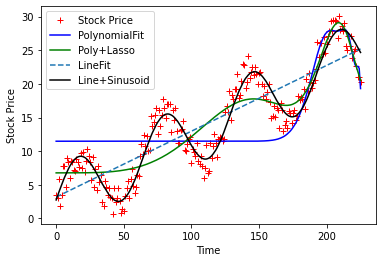

In [23]:
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat4, 'b-')
plt.plot(y2.x, yhat5, 'g-')
plt.plot(y2.x, yhat2, '--')
plt.plot(y2.x, yhat3, 'k')
plt.legend(['Stock Price', 'PolynomialFit', 'Poly+Lasso', 'LineFit', 'Line+Sinusoid'], loc='upper left')
plt.show()

### what if closed form is not possible?  Gradient descent comes to the rescue.

Let's consider solving the LineFit problem in the Gradient Descent style.

As long as our mathematical model of the system is differentiable (gradients are computable), our loss function $\mathcal{L} = (y-\hat{y})^2$ remains differentiable.

Our linear model is given by $\hat{y} = \beta_0 + \beta_1 x = X^\top\beta$ and the loss is given by $\mathcal{L} = [y - (\beta_0 + \beta_1 x)]^2 = [y-X^\top\beta]^\top[y-X^\top\beta]$

The average loss gradients for the full dataset are given by $\frac{\partial\mathcal{L}}{\partial\beta_0} = \frac{-2}{N} \sum (y-\hat{y}) $ and $\frac{\partial\mathcal{L}}{\partial\beta_1} = \frac{-2}{N} \sum X^\top(y-\hat{y})$

### the GD algorithm

* Choose the mathematical model; ensure it's continuous and differentiable.
* Initialize the model parameters to random numbers.  Usually they are sampled from standard normal distribution.
* Compute the gradient of the loss based on the current model parametric setting.
* Update the parameters using $\beta_i \leftarrow \beta_i + \eta \frac{\partial\mathcal{L}}{\partial\beta_i}$
* Repeat the last two steps until the loss minimizes to the required target or it reaches a plateau.  If the loss increases, you have done something incorrectly.

### let's implement the gradient descent algorithm for the linefit solution.

In [24]:
from tqdm.auto import tqdm

class MyLineFitViaGD:
    def __init__(self, learning_rate=0.0001, n_iters=10_000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # init parameters
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn(1)
        # gradient descent
        tq = tqdm(range(self.n_iters), desc="Iterations")
        for _ in  tq:
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = np.matmul(X, self.weights) + self.bias

            # compute the gap between true and predicted outputs.
            diff = y_predicted - y
            loss = np.sum(diff * diff)
            
            # compute gradients
            dw = (1 / n_samples) * np.matmul(X.T, diff)
            db = (1 / n_samples) * np.sum(diff)
            # update parameters
            self.weights  = self.weights - self.lr * dw
            self.bias  = self.bias -  self.lr * db
            
            # display the loss on the progress bar.
            tq.set_postfix({"Loss":loss})
            
    @property
    def parameters(self):
        return self.bias, self.weights
            
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted

### recall our linear fit dataset and construct the dataset matrices again

In [25]:
print(y2df.head())
yy = np.array(y2df.y) 
xx = np.array(y2df[["x"]])  # no need for "bias", as our GD method factors it already.

   bias  x     y
0   1.0  0  3.48
1   1.0  1  2.99
2   1.0  2  5.86
3   1.0  3  1.79
4   1.0  4  3.47


### let's now build the model via Gradient Descent

In [26]:
gdmodel = MyLineFitViaGD(learning_rate=0.0000001, n_iters=5000)
# fit the model and estimate the yhat values.
gdmodel.fit(xx, yy)
#get the learned parameters from the model.
bias, weights = gdmodel.parameters
print("Bias =", bias, " Weights =", weights)
# use the model to predict the yhat values.
yhat6 = gdmodel.predict(xx)
# estimate the loss again and display
loss = SSE(yy, yhat6)
print ("Loss =", loss)

Iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Bias = [0.15409472]  Weights = [0.11767116]
Loss = 3796.2416322109734


### let's visualize and compare the linear fits estimated by OLS and GD.

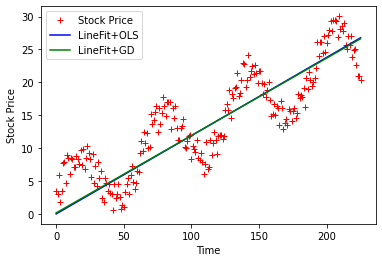

In [27]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat1, 'b-')
plt.plot(y2.x, yhat6, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'LineFit+OLS', 'LineFit+GD'], loc='upper left')
plt.show()

### let's try GD on our sinusoidal mathematical model

Now, our mathematical model of system is given by $\hat{y} = \beta_0 + \beta_1 x + \beta_2\sin(\beta_3 x)$

$\frac{\partial\mathcal{L}}{\partial\beta_0} = \frac{-2}{N} \sum (y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_1} = \frac{-2}{N} \sum X^\top(y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_2} = \frac{-2}{N} \sum \sin(\beta_3 X)^\top(y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_3} = \frac{-2}{N} \sum (\beta_2\cos(\beta_3 X) \cdot X)^\top(y-\hat{y})$

In [285]:
class MySinusoidFitViaGD:
    def __init__(self, learning_rate=0.0001, n_iters=10_000):
        self.lr = learning_rate
        self.n_iters = n_iters
        # init parameters
        self.m1 = np.abs(np.random.randn(1))
        self.m2 = np.abs(np.random.randn(1))
        self.m3 = [1] #np.abs(np.random.randn(1))
        self.bias = np.random.randn(1)
        print(f"Initial Params: Bias={self.bias[0]} M1={self.m1[0]}, M2={self.m2[0]}, M3={self.m3[0]}")
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # gradient descent
        tq = tqdm(range(self.n_iters), desc="Iterations")
        # placeholder to capture the loss trend. 
        history = []

        for _ in  tq:
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = self.predict(X)

            # compute the gap between true and predicted outputs.
            diff = y - y_predicted
            loss = SSE(y, y_predicted)
            
            # compute gradients
            dm1 = (-2 / n_samples) * np.matmul(X.T, diff)
            dm2 = (-2 / n_samples) * np.matmul(np.sin(self.m3*X).T, diff)
            dm3 = (-2 / n_samples) * np.matmul((X *self.m2* np.cos(self.m3*X)).T, diff)  
            db  = (-2 / n_samples) * np.sum(diff)
            
            # update parameters
            self.m1  = self.m1 - self.lr * dm1
            self.m2  = self.m2 - self.lr * dm2
            self.m3  = self.m3 - self.lr * dm3
            self.bias= self.bias -  self.lr * db
            
            # display the loss on the progress bar.
            tq.set_postfix({"Loss":loss})
            
            record = self.parameters
            record.append(loss)
            history.append(record)
            
        #print(history)
        #return history
        return np.array(history)
            
    @property
    def parameters(self):
        return [self.bias[0], self.m1[0][0], self.m2[0][0], self.m3[0][0]]
            
    def predict(self, X):
        y_predicted = self.bias + self.m1*X + self.m2*np.sin(self.m3*X)
        return y_predicted

In [286]:
# here we don't need the explicit bias feature column
xx = np.array(y21[['x1']])
yy = np.expand_dims(y2.y, 1) 
y21.head()

,bias,x,x1,y
0,1.0,0,0.00,3.48
1,1.0,1,0.10,2.99
2,1.0,2,0.20,5.86
3,1.0,3,0.29,1.79
4,1.0,4,0.39,3.47


### let's now build the model via Gradient Descent

Initial Params: Bias=-1.0396614975145273 M1=0.7102756405401991, M2=1.4576957226772265, M3=1


Iterations:   0%|          | 0/15000 [00:00<?, ?it/s]

Bias =  1.0132727309898923  m1 = 1.1263731059729996  m2 = 4.325078195101758  m3 = 1.0227676864752646
Loss = 698.009924884695


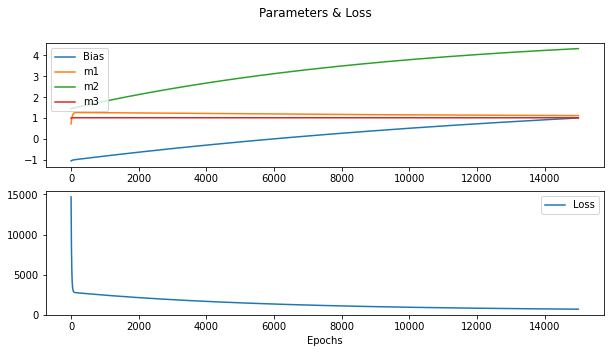

In [287]:
gdmodel = MySinusoidFitViaGD(learning_rate=0.0001, n_iters=15000)
# fit the model and estimate the yhat values.
history = gdmodel.fit(xx, yy)
#get the learned parameters from the model.
bias, w1, w2, w3 = gdmodel.parameters
print("Bias = ", bias, " m1 =", w1, " m2 =", w2, " m3 =", w3)
# use the model to predict the yhat values.
yhat7 = gdmodel.predict(xx)
# estimate the loss again and display
loss = SSE(yy, yhat7)
print ("Loss =", loss)

# let's plot the params and loss.
a1 = range(len(history))
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Parameters & Loss')
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.plot(a1, history[:,0])
ax1.plot(a1, history[:,1])
ax1.plot(a1, history[:,2])
ax1.plot(a1, history[:,3])
ax1.legend(['Bias', 'm1', 'm2', 'm3'], loc='upper left')

ax2.plot(a1, history[:,4])
ax2.set_xlabel('Epochs')
ax2.legend(['Loss'], loc='upper right')
plt.show()

### let's visualize and compare the linear fits estimated by OLS and GD.

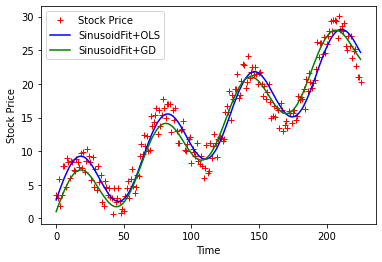

In [288]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat3, 'b-')
plt.plot(y2.x, yhat7, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'SinusoidFit+OLS', 'SinusoidFit+GD'], loc='upper left')
plt.show()